# Store
* We'll introduce the LangGraph Memory Store as a way to save and retrieve long-term memories.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 025-store.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Let's build a chatbot that can remember facts about the user
* We will build a chatbot that uses **both short-term (within-thread) and long-term (across-thread) memory**.
* We will focus on **long-term semantic memory**, that can remember facts about the user. These long-term memories will be used to create a personalized chatbot that can remember facts about the user.
* The app will **save memory "in the hot path"**, as the user is chatting with it.

## We will make use of LangGraph's Memory Store (aka Store) to build the long-term memory of our chatbot
Long-term memory:
* Scope: across sessions / threads.
* Use case: remember info about the user across sessions.
* The LangGraph Memory Store provides a way to store and retrieve information across threads in LangGraph.
* It uses an  [open source class](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/) for persistent `key-value` stores.

In [6]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects in the Store, we provide:
* The namespace (similar to directory name).
* The key (similar to file name).
* The value (similar to file content).

In [7]:
user_id = "1"
namespace_for_memory = (user_id, "memories")
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save
in_memory_store.put(namespace_for_memory, key, value)

## Let's explain the previous code in simple terms

This code demonstrates how to store data in memory using **LangGraph's InMemoryStore**. Here's a simplified explanation step-by-step:

#### Import required modules
```python
import uuid
from langgraph.store.memory import InMemoryStore
```
- **uuid**: Generates unique identifiers (useful for creating unique keys).  
- **InMemoryStore**: A tool provided by LangGraph to store key-value pairs in memory.

#### Create an in-memory storage object
```python
in_memory_store = InMemoryStore()
```
- Creates an instance of **InMemoryStore** to store data temporarily (not saved to a file or database).

#### Define identifiers
```python
user_id = "1"
namespace_for_memory = (user_id, "memories")
```
- **user_id**: Represents the ID of the user (in this case, "1").  
- **namespace_for_memory**: A tuple combining the user ID and the category ("memories"). It helps organize data for each user and context.

#### Generate a unique key
```python
key = str(uuid.uuid4())
```
- **uuid.uuid4()**: Creates a random unique identifier.  
- **str()**: Converts it to a string so it can be used as a key.

#### Prepare data to store
```python
value = {"food_preference" : "I like pizza"}
```
- **value**: A dictionary storing some information (user's food preference in this case).

#### Store the data
```python
in_memory_store.put(namespace_for_memory, key, value)
```
- Saves the dictionary (**value**) in memory under the **namespace_for_memory** and the generated **key**.  
- This means the data is stored in a specific "folder" (namespace) for the user and can be retrieved later.

## How to retrieve memories from the Memory Store
* **We use `search`** to retrieve objects from the store by namespace.
* This returns a list.

In [8]:
memories = in_memory_store.search(namespace_for_memory)

memories[0].dict()

{'value': {'food_preference': 'I like pizza'},
 'key': '4803d5a1-5c53-4f91-969e-b507b5b197c5',
 'namespace': ['1', 'memories'],
 'created_at': '2025-01-30T15:49:26.755675+00:00',
 'updated_at': '2025-01-30T15:49:26.755677+00:00',
 'score': None}

In [9]:
memories[0].key, memories[0].value

('4803d5a1-5c53-4f91-969e-b507b5b197c5', {'food_preference': 'I like pizza'})

* **We can also use `get`** to retrieve an object by namespace and key:

In [10]:
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'value': {'food_preference': 'I like pizza'},
 'key': '4803d5a1-5c53-4f91-969e-b507b5b197c5',
 'namespace': ['1', 'memories'],
 'created_at': '2025-01-30T15:49:26.755675+00:00',
 'updated_at': '2025-01-30T15:49:26.755677+00:00'}

In [11]:
memory.key, memory.value

('4803d5a1-5c53-4f91-969e-b507b5b197c5', {'food_preference': 'I like pizza'})

## OK. Now that we know more about the Memory Store, let's start building the chatbot with long-term memory

We want a chatbot that has two types of memory:

1. `Short-term (within-thread) memory`: Chatbot can persist conversational history and / or allow interruptions in a chat session.
2. `Long-term (cross-thread) memory`: Chatbot can remember information about a specific user *across all chat sessions*.

* **For short-term memory we'll use a checkpointer**.
* And **for long-term memory we'll use the LangGraph Memory Store**.

In [12]:
# Chat model 
from langchain_openai import ChatOpenAI

# Initialize the LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

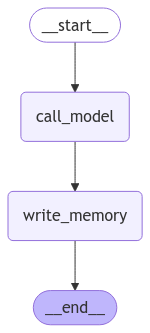

In [13]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Let's explain in simple terms the first relevant function of the previous code: call_model

The function called **`call_model`** generates a **personalized chatbot response** by using stored memory about the user. Here's a simple explanation step-by-step:

#### Function Purpose
The function:
- Loads **memory** about the user from storage.  
- **Personalizes** the chatbot's response based on the stored information and the current chat messages.

#### Input Parameters
```python
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
```
- **`state`**: Contains the current chat messages.  
- **`config`**: Provides configuration details, like the user ID.  
- **`store`**: Handles the memory storage system (where user information is saved).

#### Retrieve User ID
```python
user_id = config["configurable"]["user_id"]
```
- Gets the **user ID** from the configuration.  
- This ID helps identify the specific user's memory in storage.

#### Fetch Memory from Storage
```python
namespace = ("memory", user_id)
key = "user_memory"
existing_memory = store.get(namespace, key)
```
- **Namespace** groups memory data under "memory" and the user ID.  
- **Key** specifies what data to retrieve (e.g., "user_memory").  
- **`store.get()`** fetches the memory data for this user.

#### Check If Memory Exists
```python
if existing_memory:
    existing_memory_content = existing_memory.value.get('memory')
else:
    existing_memory_content = "No existing memory found."
```
- If memory exists, it extracts the content from storage.  
- Otherwise, it assumes no memory is available.

#### Create System Prompt with Memory
```python
system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
```
- Prepares a **system message** (instruction for the chatbot) using the memory content.  
- Example: *"You are a helpful assistant. The user likes pizza."*

#### Generate Response
```python
response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
```
- **Combines** the system message (memory) and the user's chat history.  
- Uses the **GPT-4o model** to generate a **personalized response**.

#### Return the Response
```python
return {"messages": response}
```
- Packages the response as a dictionary to send it back.

#### Example Walkthrough

**Stored Memory:**  
- User ID: 123  
- Memory: *"Name: John. Likes hiking."*

**Chat Input (New Message):**  
> "I’m planning a trip next weekend."

**Process:**
1. Fetch memory: *"Name: John. Likes hiking."*  
2. Create prompt: *"You are a helpful assistant. The user likes hiking."*  
3. Generate response using memory + input.

**Chatbot Output:**  
> "That sounds exciting, John! Are you planning to hike somewhere special?"

## OK. Now let's explain in simple terms the other relevant function in the previous code: write_memory

The function **`write_memory`** **updates and saves user memory** based on the chat history. Here's a simple explanation step-by-step:

#### Function Purpose
The function:
- **Analyzes the chat history** to identify new information about the user.  
- **Updates or overwrites memory** with the new information.  
- **Stores the updated memory** for future conversations.

#### Input Parameters
```python
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
```
- **`state`**: Contains the current chat messages.  
- **`config`**: Provides settings like the user ID.  
- **`store`**: Manages where the memory is stored.

#### Get the User ID
```python
user_id = config["configurable"]["user_id"]
```
- Retrieves the **user ID** from the configuration.  
- This ID is used to locate the user's memory in storage.

#### Fetch Existing Memory
```python
namespace = ("memory", user_id)
existing_memory = store.get(namespace, "user_memory")
```
- Defines a **namespace** (folder-like structure) based on the user ID.  
- Tries to **fetch memory** labeled as **"user_memory"** from storage.

#### Check If Memory Exists
```python
if existing_memory:
    existing_memory_content = existing_memory.value.get('memory')
else:
    existing_memory_content = "No existing memory found."
```
- If memory exists, it extracts the content.  
- Otherwise, it assumes **no prior memory** is available.

#### Analyze Chat and Generate Updated Memory
```python
system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])
```
- **Creates instructions** (from `CREATE_MEMORY_INSTRUCTION`) for the chatbot to **extract new information** about the user.  
- Combines:
  - Existing memory.  
  - Current chat history.  
- Uses the **GPT-4o model** to **analyze and generate updated memory**.

#### Save Updated Memory
```python
key = "user_memory"
store.put(namespace, key, {"memory": new_memory.content})
```
- **Saves the new memory** to storage, replacing the old one.  
- Memory is stored as a **dictionary** with the key **"memory"** for easy retrieval later.

#### Example Walkthrough

**Initial Memory:**  
- Stored: *"Name: John. Likes hiking."*

**Chat Input:**  
> "I also enjoy biking and recently visited Spain."

**Process:**
1. Fetch memory: *"Name: John. Likes hiking."*  
2. Analyze chat history: Adds *"Enjoys biking, visited Spain."*  
3. Updated memory: 
   ```
   - Name: John  
   - Likes hiking  
   - Enjoys biking  
   - Visited Spain
   ```
4. Save this updated memory.

**Result (New Memory):**
- The chatbot will remember John also enjoys biking and has been to Spain in future chats.

## Finally, let's explain the all the previous code (including the two functions) in simple terms

This code defines a **memory-enabled chatbot**. Here's a step-by-step explanation in simple terms:

#### Import Required Tools
```python
from langchain_openai import ChatOpenAI
```
- **ChatOpenAI** initializes the GPT-4o model to process user inputs and generate responses.

```python
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
```
- **StateGraph**: Allows defining the chatbot's workflow using nodes and edges (steps and connections).  
- **MemorySaver** and **BaseStore**: Handle short-term and long-term memory storage.

#### Set Up the Chat Model
```python
model = ChatOpenAI(model="gpt-4o", temperature=0)
```
- **model**: Uses GPT-4o with zero randomness (**temperature=0**) for consistent responses.

#### Define Chatbot Instructions
```python
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""
```
- Provides system instructions for the chatbot.  
- Includes **memory** about the user to make responses personalized.

```python
CREATE_MEMORY_INSTRUCTION = """You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""
```
- Specifies **how to update memory** based on the chat history, such as preferences, goals, or personal details.  
- Ensures updates are factual and organized as a **bulleted list**.

#### Process Messages and Memory

**Step 1: Retrieve Memory and Generate Response**
```python
def call_model(state, config, store):
```
- **Purpose**: Fetches existing memory and uses it to personalize the chatbot’s response.

**Key steps:**
1. **Get user ID** from the input configuration.  
2. **Retrieve memory** for the user from the store.  
3. Use memory and chat history to generate a response using the **GPT-4o model**.  
4. Return the updated messages.

**Step 2: Update Memory**
```python
def write_memory(state, config, store):
```
- **Purpose**: Analyzes the chat history and **saves new information** about the user in memory.

**Key steps:**
1. **Retrieve existing memory** (if any).  
2. Format a prompt asking the model to **extract new information** from the chat.  
3. **Save the updated memory** in the store, overwriting old data.

#### Build the Workflow (Graph)
```python
builder = StateGraph(MessagesState)
```
- **StateGraph** defines the chatbot's process as a series of steps.

**Nodes (steps):**
1. **"call_model"**: Generate a response using memory.  
2. **"write_memory"**: Update memory after responding.  

**Edges (connections):**
- Flow starts at **START**, then:
  - Goes to **call_model**, generates a response.  
  - Moves to **write_memory** to update memory.  
  - Ends at **END**.

#### Memory Management
```python
across_thread_memory = InMemoryStore()
```
- **InMemoryStore**: Saves memory across conversations (long-term storage).  

```python
within_thread_memory = MemorySaver()
```
- **MemorySaver**: Handles memory within a single session (short-term storage).

#### Compile and Visualize the Workflow
```python
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)
```
- Combines the steps into a **working chatbot pipeline** with memory support.

```python
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
```
- **Visualizes** the workflow graph, showing nodes and connections.

#### What Does It Do?
1. **Remembers user information** like preferences, interests, or goals between sessions.  
2. **Personalizes responses** based on stored memory.  
3. **Updates memory dynamically** after each chat session.  

#### Real-Life Example:
**Input 1:**  
> "Hi, I’m John and I love hiking!"  

**Response 1:**  
> "Nice to meet you, John! Hiking is a great hobby. Do you have a favorite trail?"  

**Memory Updated:**  
- Name: John  
- Hobby: Hiking  

**Input 2 (next session):**  
> "I’m planning a trip to the mountains."  

**Response 2 (uses memory):**  
> "That sounds perfect for someone who loves hiking, John! Which mountains are you planning to visit?"  

This interaction shows how memory is used to **enhance conversations** and **personalize responses** based on prior chats.

## When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work together in practice:

In [14]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Julio")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Julio
================================== Ai Message ==================================

Hello, Julio! It's nice to meet you. How can I assist you today?


In [15]:
# User input 
input_messages = [HumanMessage(content="I like to drive a vespa around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to drive a vespa around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Julio! San Francisco is such a beautiful city, and riding a Vespa must be a great way to explore it. Do you have any favorite spots you like to visit while riding around?


* We're using the `MemorySaver` checkpointer for within-thread memory.
* This saves the chat history to the thread.
* We can look at the chat history saved to the thread:

In [16]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Julio
================================== Ai Message ==================================

Hello, Julio! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I like to drive a vespa around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Julio! San Francisco is such a beautiful city, and riding a Vespa must be a great way to explore it. Do you have any favorite spots you like to visit while riding around?


## Let's explain in simple terms what we just did

The previous code demonstrates how the **chatbot with memory** works by processing user inputs and updating both **short-term** and **long-term memory**. Here’s a simple explanation step-by-step:

#### Set Configuration for Memory
```python
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
```
- **`thread_id`:** Used for **short-term memory** within a single session (temporary memory).  
- **`user_id`:** Used for **long-term memory** across multiple sessions (persistent memory).  
- Both IDs are set to **"1"** to identify the user and thread.

#### Process First Input Message
```python
input_messages = [HumanMessage(content="Hi, my name is Julio")]
```
- **User Input:** "Hi, my name is Julio."  
- This is the **first message** sent to the chatbot.

**Run the Graph (Workflow):**
```python
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
```
- **Processes the input** through the chatbot’s workflow graph:
  1. **Fetches existing memory.**  
  2. **Personalizes the response** based on memory.  
  3. **Updates memory** to include new information (e.g., Julio’s name).  
- **Outputs the chatbot’s response** by printing it to the screen.

#### Process Second Input Message
```python
input_messages = [HumanMessage(content="I like to drive a vespa around San Francisco")]
```
- **User Input:** "I like to drive a vespa around San Francisco."  
- This is the **second message** sent to the chatbot.

**Run the Graph (Workflow):**
```python
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
```
- **Processes the second input** in the same way:
  1. **Fetches updated memory** (now knows the user’s name is Julio).  
  2. **Personalizes the response** by referring to previous information.  
  3. **Updates memory** with new details (likes driving a Vespa in San Francisco).  
- **Outputs the chatbot’s response** using the new memory.

#### Review Stored Memory (Short-Term)
```python
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()
```
- **Accesses the current session’s state** using the thread ID.  
- **Retrieves all messages** exchanged so far (chat history).  
- **Prints the conversation** for review.

#### What Happens Behind the Scenes?

1. **First Input (Julio's Name):**  
   - No prior memory, so it’s stored: *"Name: Julio."*  
   - Response might acknowledge the name: *"Hi Julio! How can I assist you today?"*

2. **Second Input (Vespa in San Francisco):**  
   - Memory already includes *"Name: Julio."*  
   - New info added: *"Likes to drive a Vespa in San Francisco."*  
   - Response might say: *"That sounds like a fun way to explore San Francisco, Julio!"*

3. **Final Review:**  
   - Prints all chat messages and shows the current memory used during the session.

#### Example Final Memory
```
- Name: Julio
- Likes to drive a Vespa
- Location: San Francisco
```
The chatbot can now **use this memory** in future conversations without asking for repeated details.

## Now we can check if the memory was saved to the store
* Recall that we compiled the graph with the store: 

```python
across_thread_memory = InMemoryStore()
```

* And, we added a node to the graph (`write_memory`) that reflects on the chat history and saves a memory to the store.
* Let's see if the memory was saved to the store:

In [17]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'memory': "**Updated User Information:**\n- User's name is Julio.\n- Likes to drive a Vespa.\n- Rides around San Francisco."},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2025-01-30T15:49:39.048129+00:00',
 'updated_at': '2025-01-30T15:49:39.048133+00:00'}

## Now, let's use a different thread_id to simulate a new conversation with the same User
* We will use a *new thread* with the *same user ID*.
* We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [18]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend I drive with my vehicle in my town?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend I drive with my vehicle in my town?
================================== Ai Message ==================================

Hi Julio! Since you enjoy riding your Vespa around San Francisco, there are some fantastic routes you might love. Consider taking a ride through the scenic views of the Golden Gate Bridge, or perhaps a leisurely drive through Golden Gate Park. The winding roads of Lombard Street can be a fun challenge, and the Embarcadero offers beautiful waterfront views. If you're up for a bit of a climb, Twin Peaks provides a stunning panoramic view of the city. Enjoy your ride!


* Excellent. As you can see, **the chatbot remembers our vehicle and our city from our previous conversation**.

## Let's review what we just did

The previous code demonstrates how the **chatbot with memory** handles a **new conversation thread** while still using the **same user memory**. Here's a simple explanation step-by-step:

#### Set a New Configuration
```python
config = {"configurable": {"thread_id": "2", "user_id": "1"}}
```
- **`thread_id`: "2"** – Starts a **new conversation thread** (new session).  
- **`user_id`: "1"** – Keeps the **same user ID**, so it can **access previously stored memory** (long-term memory).  

> **Why this matters?**  
Even though this is a **new session**, it still **remembers the user’s details** because the user ID hasn’t changed.

#### Provide New User Input
```python
input_messages = [HumanMessage(content="Hi! Where would you recommend I drive with my vehicle in my town?")]
```
- **User Input:** The user asks for driving recommendations in their town.  
- The chatbot will **personalize its response** based on what it **already knows** about the user.

#### Process the Input with Memory
```python
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
```
- **Runs the chatbot workflow (graph):**  
  1. **Fetches memory:** Looks up memory for **user_id = 1**.  
  2. **Uses memory:** Knows the user’s name is **Julio** and that they like **driving a Vespa** in **San Francisco**.  
  3. **Generates a response:** Suggests places relevant to **Vespa rides** in **San Francisco**.  
  4. **Outputs the response.**

#### What Happens Behind the Scenes?

**Memory Used:**
- **Name:** Julio  
- **Likes to drive a Vespa**  
- **Location:** San Francisco  

**Example Response:**
> "Hi Julio! Since you enjoy driving a Vespa around San Francisco, I’d recommend exploring the scenic views along the Embarcadero or cruising through Golden Gate Park!"

#### Key Takeaways

1. **Separate Sessions, Same Memory:**  
   - The chatbot treats this as a **new conversation** (new thread).  
   - It still **remembers previous details** because it uses the **same user ID**.

2. **Personalized Responses:**  
   - The chatbot uses **long-term memory** to make responses relevant, even in a new session.  

3. **Practical Use:**  
   - Allows users to have **multiple conversations** without repeating personal details.  
   - Useful for chatbots designed to handle **ongoing relationships** with users.  

#### Why is the New Thread Important?
- **Thread ID = 1**: Might focus on introductions and learning about the user.  
- **Thread ID = 2**: Focuses on travel recommendations without losing prior context.  

This setup allows the chatbot to **manage multiple topics** while still knowing who the user is, creating a **seamless, personalized experience** across sessions.

## But, where is this long-term memory being saved? And, will this long-term memory persist if we close our application and open it again?

#### Where is the long-term memory being saved?
   - The long-term memory is saved in the `BaseStore` implementation used for `store`, which in your case is specified as `InMemoryStore()` and is assigned to `across_thread_memory`.

   - **Key components for memory saving**:
     - **Namespace and Key**: Memory is saved with a namespace (`("memory", user_id)`) and a key (`"user_memory"`).
     - **Memory content**: The memory content is stored as a dictionary, with the key `{"memory": <new_memory_content>}`.

#### How is the memory persistent?
   - The persistence of the memory depends on the implementation of `BaseStore`. In this case, `InMemoryStore` is a temporary, in-memory store that does not persist data to disk or any external storage.

#### Would the memory persist if the app is closed and reopened?
   - No, the memory **would not persist** if the app is closed and reopened, because `InMemoryStore` only holds the memory in the application's runtime memory. When the application shuts down, all data in `InMemoryStore` is lost.

#### What is the application's runtime memory?

The application runtime memory is like your computer's "working space" where all the temporary data and processes needed for an app to run are stored while the app is open. Think of it as a whiteboard:

1. **Temporary Storage**: The runtime memory is used to hold information the app needs *right now*. For example, when you're typing a message in a chat app, the app stores your typed text in runtime memory before it's sent.

2. **Cleared When Closed**: Just like wiping a whiteboard when you're done using it, runtime memory is cleared when the app is closed or your computer restarts. This is why, if an app doesn’t save its data to a more permanent place (like a file or a database), you lose everything stored in the runtime memory.

3. **Depends on RAM**: Runtime memory lives in your computer’s **RAM (Random Access Memory)**, which is much faster than long-term storage (like your hard drive) but is also temporary.

#### Example
Imagine you're using a notepad app. If you write something but don’t save it, and then close the app, the text is gone forever. That’s because the text was only stored in runtime memory and wasn’t saved to permanent storage (like your computer’s hard drive). If you hit "Save," the text is written to permanent storage, so you can reopen it later.

#### Making the memory persistent across sessions
To make the long-term memory in the provided LangGraph code persistent and saved to your hard disk, you would need to replace the InMemoryStore (which only keeps data in runtime memory) with an alternative that writes to persistent storage, such as a SQLite database, a file, or another form of long-term storage. This is still a very young field in LangGraph, we will add more about it as soon as we see a robust implementation in the LangGraph documentation.

## And, with that, we could continue our conversation
* For example:

In [19]:
# User input 
input_messages = [HumanMessage(content="Great, are there any Whole Foods stores nearby that I can check out? I like a health food after driving.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any Whole Foods stores nearby that I can check out? I like a health food after driving.
================================== Ai Message ==================================

Absolutely, Julio! There are several Whole Foods locations in San Francisco where you can grab some healthy food after your Vespa rides. Here are a few options:

1. **Whole Foods Market on Market Street** - Located at 399 4th Street, it's right in the SoMa area and quite accessible.
2. **Whole Foods Market on California Street** - Situated at 1765 California Street, this one is in the Pacific Heights neighborhood.
3. **Whole Foods Market on Haight Street** - Found at 690 Stanyan Street, it's near Golden Gate Park, which could be convenient if you're riding around there.

These stores should have a great selection of health foods for you to enjoy. Safe travels!


## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 025-store.py
* In terminal, make sure you are in the directory of the file and run:
    * python 025-store.py